# Análisis de "falsos positivos" en la encriptación de imágenes utilizando el cifrado Hill

### Ricardo A. Marino R.
### Departamento de Matemáticas y Ciencias de la Computación
### Universidad Nacional de Colombia

## 1. Introducción

El presente "notebook" está hecho con el fin de analizar los casos en los cuáles el cifrado Hill, aplicado a imágenes, genera una encriptación *débil* que revela gran cantidad de patrones de la imagen original. En específico, se exponen casos no triviales en los cuáles, aunque la llave utilizada para cifrar la imagen es válida, la encriptación que se genera es débil.

*Librerías para utilizar en los códigos*

In [ ]:
from PIL import Image
import requests
from PIL import ImageOps
from IPython.display import display
import urllib.request
import numpy as np
import math

## 2. Calidad de encriptamiento de una imagen utilizando PSNR (Peak-signal-to-noise-ratio)

Con el objetivo de definir de una manera precisa la calidad de encriptamiento de una imagen, se decide utilizar la norma [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio). Este concepto es un término utilizado en ingeniería para el decribir el radio entre la máxima potencia posible de la señal y el poder del ruido corruptor que afecta la fidelidad de su representación. Por esta razón, resulta útil considerarlo como norma para cuantizar la calidad de encriptación entre una imagen original y su resultado después de aplicar el cifrado Hill.

### 2.1 Definción de norma PSNR

PSNR se puede definir de una manera mas sencilla utilizando Error Medio Cuadrado ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)). Dada una imagen monocromática $I$ de $mxn$ y su encriptación $K$, MSE está definido como:
$$\text{MSE} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}[I(i,j) - K(i,j)]^{2}.$$

La norma PSNR se define como:
$$\begin{aligned}\text{PSNR} &= 10 \cdot \log_{10}\left( \frac{\text{MAX}_{I}^{2}}{\text{MSE}}\right)\\
&= 20 \cdot \log_{10}\left( \frac{\text{MAX}_{I}}{\sqrt{\text{MSE}}}\right)\\
&= 20 \cdot \log_{10}(\text{MAX}_{I}) - 10 \cdot \log_{10}(\text{MSE})\end{aligned}$$

Donde $\text{MAX}_{I}$ es la máximo valor posible para un pixel. En nuestro caso, trabajaremos las imágenes en escala de grises, de modo que el máximo valor posible para un pixel será $255$.

### *Implementacioń norma PSNR*

In [ ]:
def PSNR(imgPath1, imgPath2):
    img1 = Image.open(imgPath1)
    img2 = Image.open(imgPath2)
    new_img1 = img1.convert("L")
    new_img2 = img2.convert("L")
    
    MSE = 0
    
    for j in range(0, new_img1.height):
        for i in range(0, new_img1.width):
            MSE += (new_img1.getpixel((i,j)) - new_img2.getpixel((i,j)))**2
    MSE = MSE/(new_img1.height*new_img1.width)
    psnr = 20*math.log(255, 10) - 10*math.log(MSE, 10)
    return psnr

## 3 Falsos Positivos

### 3.1 Imágenes con grandes porciones del mismo color

El primer caso en el cuál la encriptación de Hill genera "falsos positivos" es cuando la imagen contiene grandes porciones de un mismo color. En este caso, sin importar el tipo de llave que se utilice, la imagen encriptada será de mala calidad. Veámos algunos ejemplos:

### *Cifrado para imágenes Hill*

In [ ]:
def EncryptImage(key, url, name):
    """
    Description
    -----------
    Given m(the dimension of the key matrix), the key(matrix) and a
    url of the image, it encrypts the image of the url using the key.
    Finally, the encrypted image is displayed and then saved in
    'result.pgm' file. 
    
    If the key is not valid after three times, it
    uses a valid random key generated.

    Parameters
    ----------
    key : 2-dimensional list or np.array ie [[1, 2], [5, 6]]
        The mxm matrix to use as a key in the Hill cipher
    url : string
        The url of the image to encrypt
    Returns
    -------
    2-dimensional list : The key used to encrypt the image
    """
    m = len(key)
    
    response = requests.get(url)
    urllib.request.urlretrieve(url, name + ".jpg")
    img = Image.open(name + ".jpg")
    encryptedImg = img.convert("L")

    # Resize image as needed, the image width must be a multiple
    # of m
    if encryptedImg.width % m != 0:
        diff = m - (encryptedImg.width % m)
        encryptedImg = ImageOps.expand(encryptedImg, border=(0,0, diff, 0), fill = 0)
    
    # Iterate over each row of the image height taking at each step
    # m pixels to transform them into a new m pixels
    for y in range(0, encryptedImg.height):
        rowPixels = []
        for x in range(0, encryptedImg.width):
            if x % m == 0 and x > 0:
                # Transform the m pixels making the dot product between them and the
                # key matrix
                newRowPixels = list(np.dot(rowPixels, key))
                newRowPixels = [(i % 256) for i in newRowPixels]
                for i in range(x - m, x):
                    encryptedImg.putpixel((i,y), int(newRowPixels[i - (x-m)]))
                rowPixels = []
            
            rowPixels.append(encryptedImg.getpixel((x,y)))
    
    # Show the image
    encryptedImg.show()
    encryptedImg.save("new_"+ name + ".png")

Primera imagen para encriptar:
![Tux](https://upload.wikimedia.org/wikipedia/commons/5/56/Tux.jpg)

Primera imagen encriptada:

In [ ]:
n = 256
key = [[167, 8, 48], [54, 107, 25], [170, 184, 107]]
EncryptImage(key, "https://upload.wikimedia.org/wikipedia/commons/5/56/Tux.jpg", "tux")

!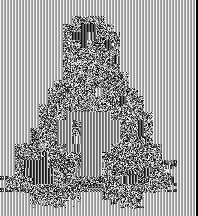

In [ ]:
PSNR("tux.jpg", "new_tux.png")

8.138981632775078

Ahora, veamos la norma PSNR con una imagen sin grandes porciones del mismo color

In [ ]:
n = 256
key = [[167, 8, 48], [54, 107, 25], [170, 184, 107]]
EncryptImage(key, "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Felis_silvestris_catus_lying_on_rice_straw.jpg/220px-Felis_silvestris_catus_lying_on_rice_straw.jpg", "cat")

Segunda imagen para encriptar

![Cat](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Felis_silvestris_catus_lying_on_rice_straw.jpg/220px-Felis_silvestris_catus_lying_on_rice_straw.jpg)

Segunda imagen encriptada

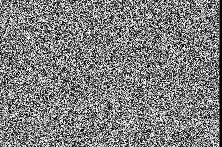

In [ ]:
PSNR("cat.jpg", "new_cat.png")

8.27514788867471

No obstante, observemos la norma PSNR con imágenes no encriptadas

Tercera imagen sin encriptar

![Barco](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/PSNR-example-base.png/1280px-PSNR-example-base.png)

![Barco2](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PSNR-example-comp-30.jpg/1280px-PSNR-example-comp-30.jpg)

In [ ]:
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/PSNR-example-base.png/1280px-PSNR-example-base.png", "psnr1.png")
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PSNR-example-comp-30.jpg/1280px-PSNR-example-comp-30.jpg", "psnr2.jpg")
PSNR("psnr1.png", "psnr2.jpg")

29.812901077542527

### 3.2 Imágenes cifradas con cierto tipo de matrices

Si bien las matrices utilizadas para el cifrado Hill(blanco y negro) son aquellas que son invertibles módulo 255, existen matrices que cumplen con esta condición pero generan imágenes pobremente cifradas. Veamos algunos ejemplos

Cuarta imagen sin encriptar:

![Cat](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/600px-Cat03.jpg)

In [ ]:
key = [[255, 8, 3], [0, 1, 7],[0, 0, 1]]
EncryptImage(key, "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/600px-Cat03.jpg", "example2")

Cuarta imagen encriptada:

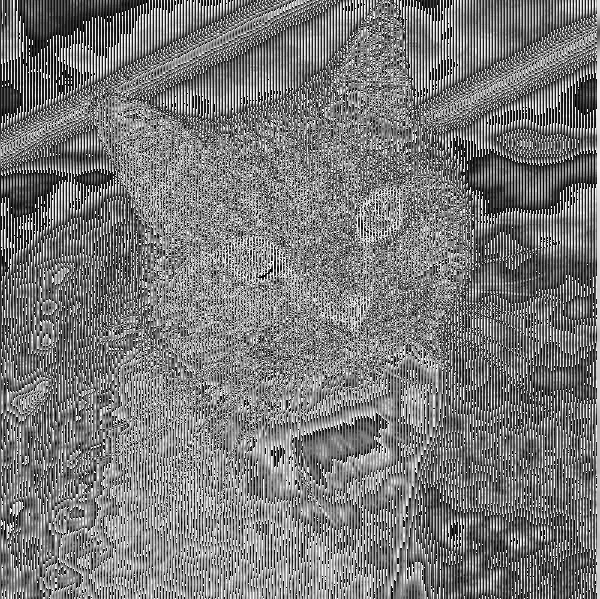

In [ ]:
PSNR("example2.jpg", "new_example2.png")

7.756417420825116

Como se puede ver, el encriptamiento no oculta la silueta del gato de la imagen haciendo de este un encriptamiento defectuoso. Utilicemos la misma matriz para encriptar otras imágenes

Quinta imagen sin encriptar

![panda](https://upload.wikimedia.org/wikipedia/commons/5/54/Panda_Cub_%284274178112%29.jpg)

In [ ]:
key = [[255, 260, 240], [0, 240, 220],[0, 0, 200]]
EncryptImage(key, "https://upload.wikimedia.org/wikipedia/commons/5/54/Panda_Cub_%284274178112%29.jpg", "example3")

Quinta imagen encriptada

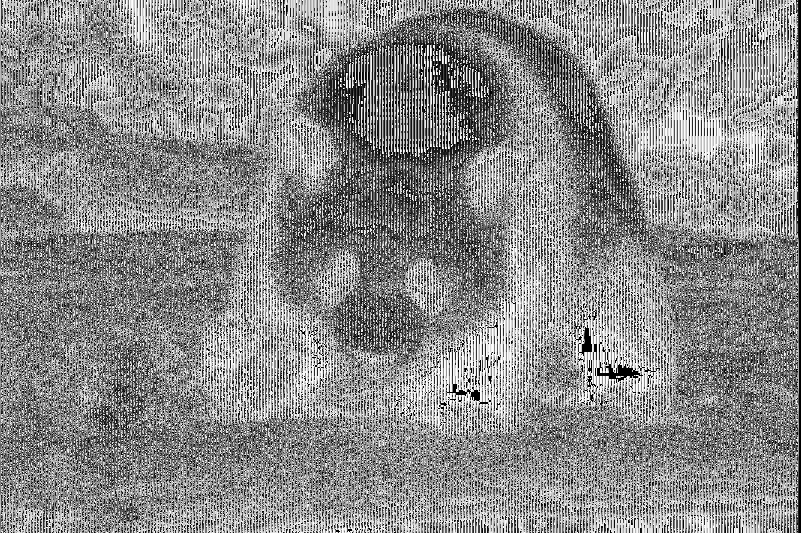

In [ ]:
PSNR("example3.jpg", "new_example3.png")

6.077208107926829

Al igual que con la anterior imágen, observamos que la imagen encriptada revela buena cantidad de la silueta de los objetos en la imagen, de modo que consideramos esta como una mala encriptación. No obstante, podemos dar un definición mas formal de **Mala encriptación**.

**Mala Encriptación**: Una imagen encriptada con el método Hill se considera una mala encriptación si la norma PSNR de esta y su imagen original es mayor que $15$.

Como es de esperar, se define como **Buena encriptación**, las imágenes encriptadas cuya norma PSNR con la imagen original es menor que $15$.

Encriptemos ahora las mismas imagenes pero utilizando matrices diferentes para ver una comparación de malas y buenas encriptaciones

Sexta imagen sin encriptar

![cat](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/600px-Cat03.jpg)

In [ ]:
key2 = [[167, 8, 48], [54, 107, 25], [170, 184, 107]]
EncryptImage(key2, "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/600px-Cat03.jpg", "example4")

Sexta imagen encriptada:

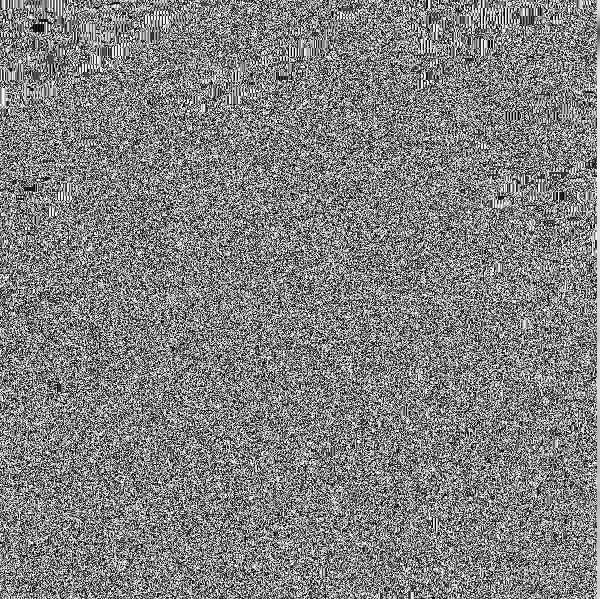

In [ ]:
PSNR("example4.jpg", "new_example4.png")

8.499966933652033

Séptima imágen sin encriptar

![panda](https://upload.wikimedia.org/wikipedia/commons/5/54/Panda_Cub_%284274178112%29.jpg)

In [ ]:
EncryptImage(key2, "https://upload.wikimedia.org/wikipedia/commons/5/54/Panda_Cub_%284274178112%29.jpg", "example5")

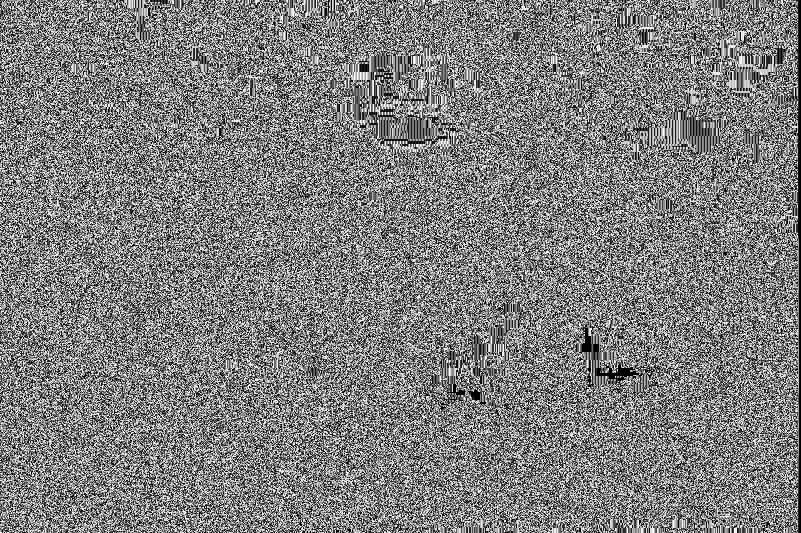

In [ ]:
PSNR("example5.jpg", "new_example5.png")

7.511799143908917

Como se puede apreciar, si bien la norma PSNR de las imaǵenes encriptadas 4 y 5 es menor que de las imágenes encriptadas 6 y 7 respectivamente, las imágenes encriptadas 4 y 5 revelan gran parte de la silueta y contorno de los objetos presentes en las imágenes. Esto sucede porque la matriz utilizada para encriptar las imágenes 4 y 5 es una matriz diagonal y tiene valores muy pequeños, de modo que al cifrar 3 pixeles con también valores pequeños el primero de ellos es transformado a un valor muy cercano al original(además de que es el único valor tomado en cuenta porque la primera columna de la matriz es nula excepto en la primera fila), de igual modo los otros 2 pixeles son mutiplicados por valores muy pequeños y luego sumados entre si para resultar en otro valor igualmente pequeño, muy cercano al original. Por esta razón las fronteras de los objetos se alcanzan a percibir después de ser cifradas las imágenes, porque estas fronteras usualemente son de colores negro o blanco, es decir, valores muy pequeños o muy grandes que al ser mutiplicados por la matriz utilizando módulo $256$ resultan en pixeles muy cercanos a los originales.

Asímismo, se puede observar que al utilizar matrices con la mayoría de entradas mas cerca de $128$ el encriptamiento no revela siluetas o contornos de las imaǵenes como en las imágenes encriptadas 6 y 7.